In [1]:
! pip install -q kaggle
! pip install --upgrade --force-reinstall --no-deps kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 3.8 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=dbc1000f6a4bfb46158d7a1acee374aeb2a71be35ffbf222c6f2757cfe11aa40
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon May 30 17:07:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive')
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c histopathologic-cancer-detection

Mounted at /content/drive
100% 6.29G/6.31G [00:41<00:00, 200MB/s]
100% 6.31G/6.31G [00:41<00:00, 163MB/s]


In [4]:
import zipfile
zip = zipfile.ZipFile('histopathologic-cancer-detection.zip')
zip.extractall()

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Новый раздел

In [6]:
import cv2 as cv
from torch.utils.data import Dataset
import os
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
import cv2 as cv
import pandas as pd
from PIL import Image
from torchvision import transforms
import torch
from tqdm import tqdm
from torch import nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision
from sklearn.model_selection import train_test_split
import numpy as np
import os
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

(220025, 2)


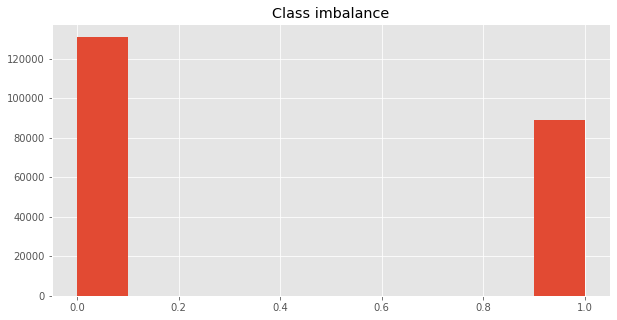

In [7]:
train_data = pd.read_csv('/content/train_labels.csv')
subm_df = pd.read_csv('/content/sample_submission.csv')
fig, plot = plt.subplots(1, 1, figsize=(10, 5))
plot.hist(train_data['label'])
plot.set_title("Сlass imbalance")
print(train_data.shape)

In [8]:
train, val = train_test_split(train_data, stratify=train_data.label, test_size=0.2)
path = '/content/train'
test_path = '/content/test'
batch_size = 256

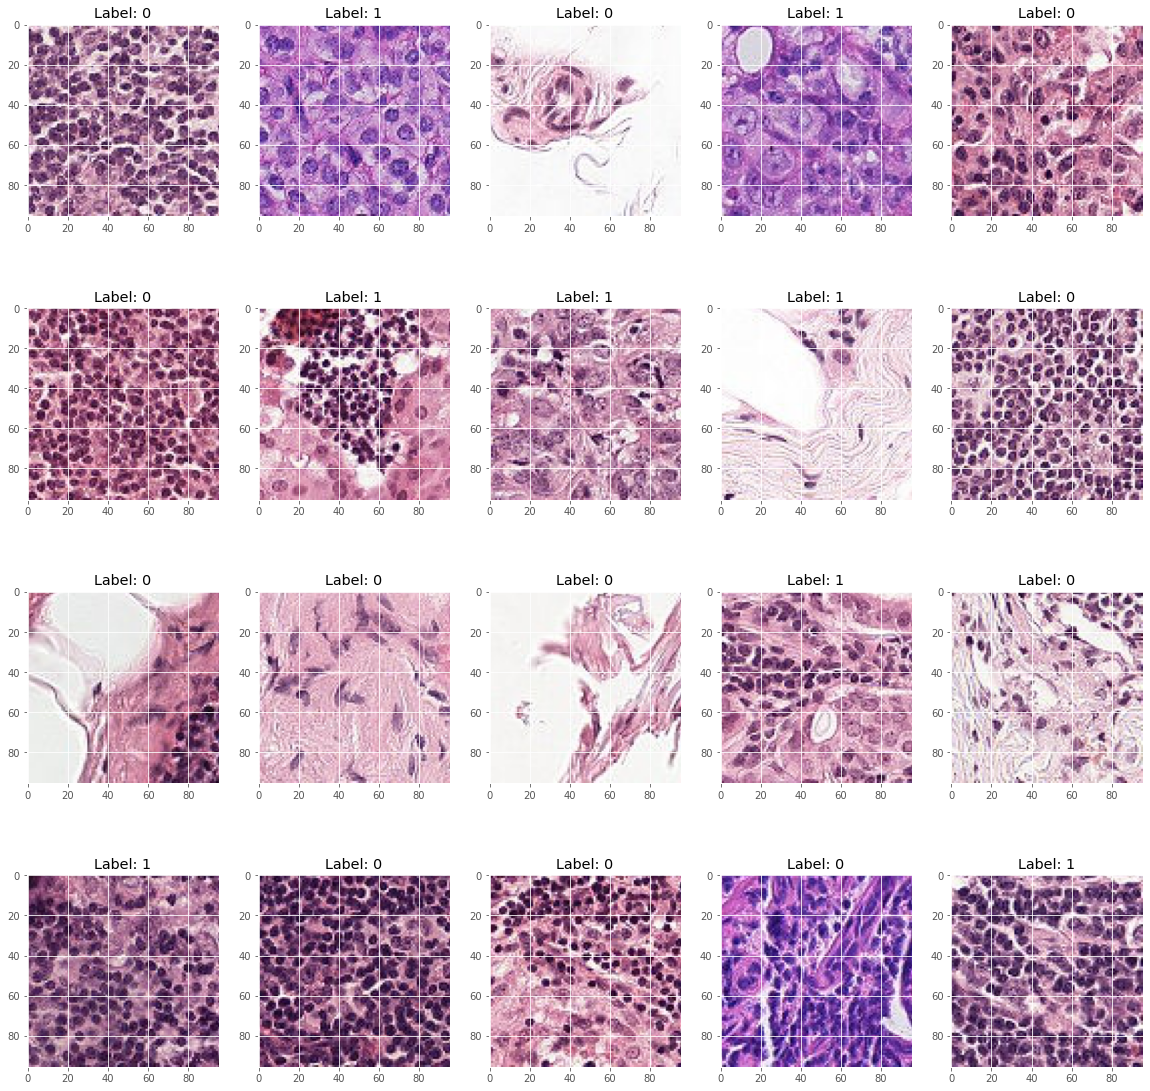

In [9]:
fig = plt.figure(figsize=(20, 20))
train_imgs = os.listdir(path)
for idx, img in enumerate(np.random.choice(train_imgs, 20)):
    ax = fig.add_subplot(4, 20//4, idx+1)
    im = Image.open(path + '/' + img)
    plt.imshow(im)
    lab = train_data.loc[train_data['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title(f'Label: {lab}')   

In [10]:
class MyDataset(Dataset):
    def __init__(self, data, data_path, transform=None):
        super().__init__()
        self.df = data.values
        self.data_path = data_path
        self.transform = transform
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        name, label = self.df[index]
        img_path = os.path.join(self.data_path, name + '.tif')
        img = cv.imread(img_path)
        if self.transform is not None:
            img = self.transform(img)
        return img, label
        

In [11]:
train_transform = transforms.Compose([transforms.ToPILImage(),
                                    transforms.Pad(64, padding_mode='reflect'),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomVerticalFlip(),
                                    transforms.RandomRotation(40),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean = [0.5, 0.5, 0.5], std= [0.5, 0.5, 0.5])])

val_transform = transforms.Compose([transforms.ToPILImage(),
                                   transforms.Pad(64, padding_mode='reflect'),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

test_transform = val_transform

In [12]:
train_dataset = MyDataset(train, path, train_transform)
valid_dataset = MyDataset(val, path, val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size // 4, shuffle=False, num_workers=0)

In [13]:
#https://github.com/lukemelas/EfficientNet-PyTorch/blob/2eb7a7d264344ddf15d0a06ee99b0dca524c6a07/efficientnet_pytorch/model.py#L143
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=2),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.avg = nn.AvgPool2d(8)
        self.fc = nn.Linear(512, 2)

    def forward(self,x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.avg(x)
        x = x.view(-1, 512)
        x = self.fc(x)
        return x

In [43]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
print(model)
device

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNor

device(type='cuda', index=0)

In [44]:
model.load_state_dict(torch.load("/content/model_15.ckpt"))
model.eval();

In [45]:
lr, num_epoch = 0.05, 30
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [46]:
train_accu, train_losses = [], []
def train(loader):
    torch.cuda.empty_cache()
    running_loss, correct, total = 0, 0, 0
    for imgs, labels in tqdm(loader):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    train_loss = running_loss / len(loader)
    accu = 100. * correct / total
    train_accu.append(accu)
    train_losses.append(train_loss)
    print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))

In [47]:
eval_accu, eval_losses = [], []
def val(loader):
    torch.cuda.empty_cache()
    running_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in tqdm(loader):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
        
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    eval_loss = running_loss / len(loader)
    accu = 100. * correct / total
    eval_accu.append(accu)
    eval_losses.append(eval_loss)
    print('Val Loss: %.3f | Accuracy: %.3f'%(eval_loss,accu)) 

100%|██████████| 688/688 [18:30<00:00,  1.61s/it]


Train Loss: 0.287 | Accuracy: 88.154


100%|██████████| 688/688 [03:01<00:00,  3.80it/s]


Val Loss: 0.551 | Accuracy: 79.632


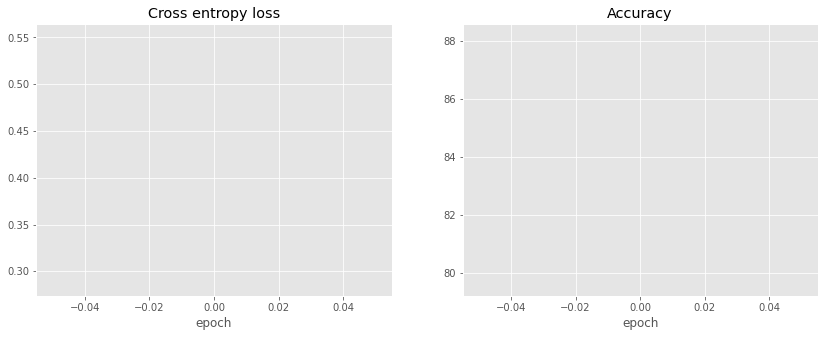

100%|██████████| 688/688 [18:44<00:00,  1.63s/it]


Train Loss: 0.228 | Accuracy: 91.046


100%|██████████| 688/688 [03:03<00:00,  3.76it/s]


Val Loss: 0.335 | Accuracy: 86.858


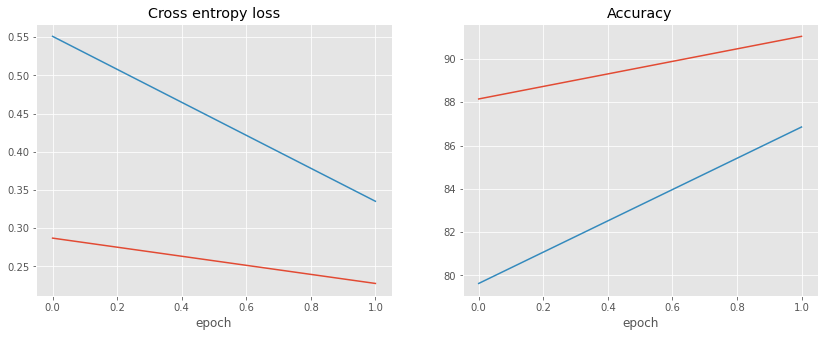

100%|██████████| 688/688 [18:26<00:00,  1.61s/it]


Train Loss: 0.201 | Accuracy: 92.275


100%|██████████| 688/688 [02:58<00:00,  3.85it/s]


Val Loss: 0.291 | Accuracy: 88.758


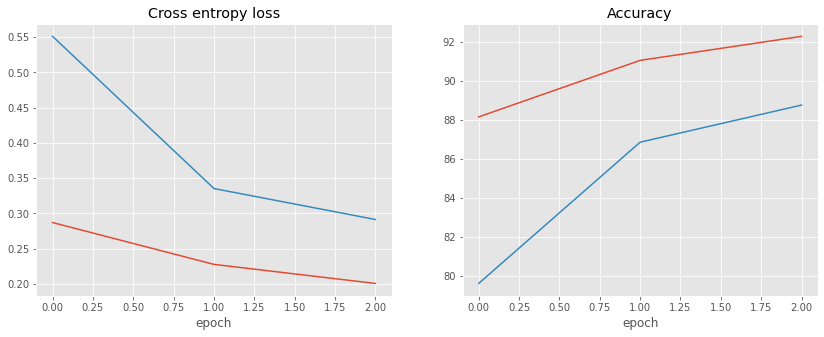

100%|██████████| 688/688 [18:35<00:00,  1.62s/it]


Train Loss: 0.182 | Accuracy: 93.208


100%|██████████| 688/688 [02:59<00:00,  3.83it/s]


Val Loss: 0.276 | Accuracy: 89.544


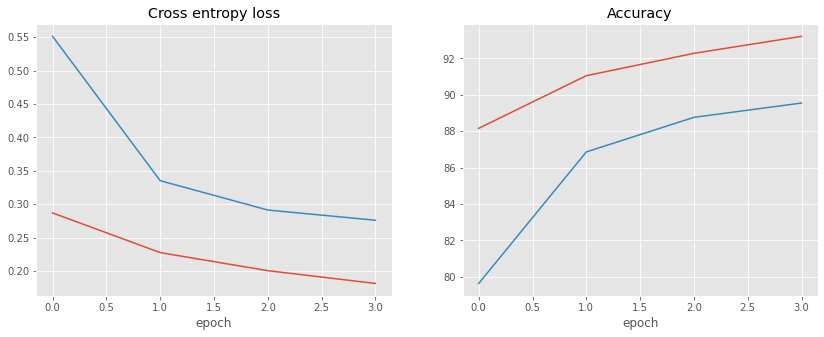

100%|██████████| 688/688 [18:28<00:00,  1.61s/it]


Train Loss: 0.171 | Accuracy: 93.653


100%|██████████| 688/688 [02:59<00:00,  3.83it/s]


Val Loss: 0.287 | Accuracy: 88.985


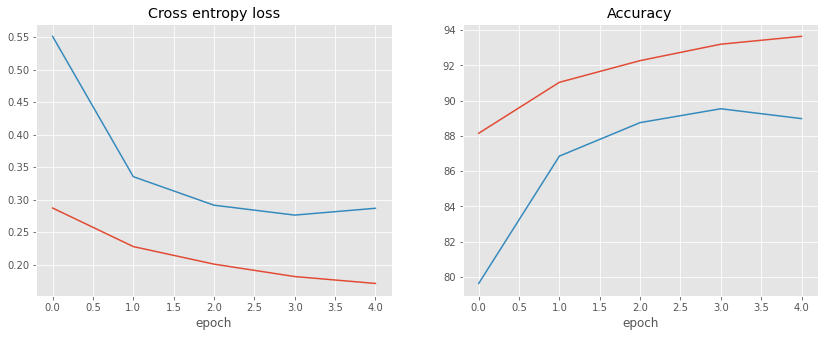

100%|██████████| 688/688 [18:21<00:00,  1.60s/it]


Train Loss: 0.164 | Accuracy: 93.920


100%|██████████| 688/688 [02:59<00:00,  3.84it/s]


Val Loss: 0.255 | Accuracy: 90.256


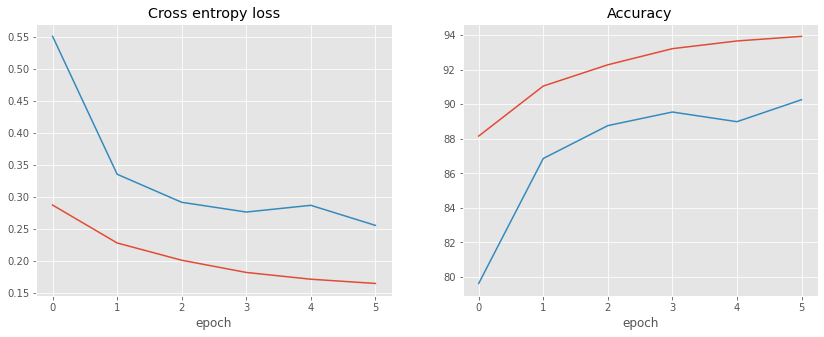

100%|██████████| 688/688 [18:26<00:00,  1.61s/it]


Train Loss: 0.157 | Accuracy: 94.215


100%|██████████| 688/688 [02:57<00:00,  3.87it/s]


Val Loss: 0.225 | Accuracy: 91.383


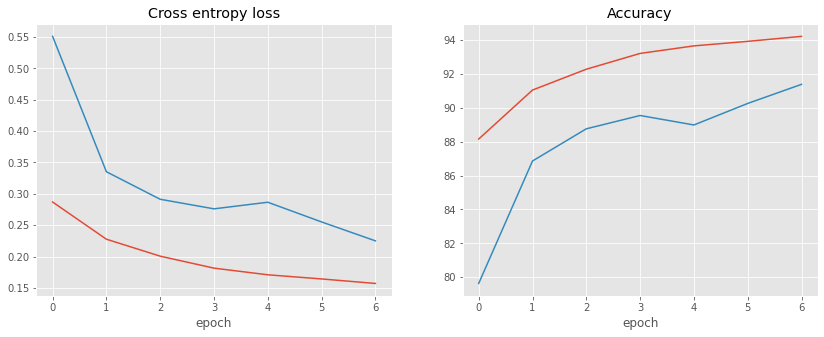

100%|██████████| 688/688 [18:26<00:00,  1.61s/it]


Train Loss: 0.153 | Accuracy: 94.361


100%|██████████| 688/688 [02:59<00:00,  3.83it/s]


Val Loss: 0.224 | Accuracy: 91.708


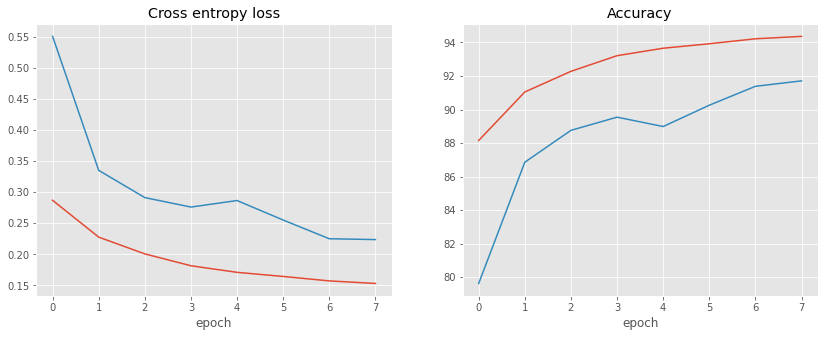

100%|██████████| 688/688 [18:31<00:00,  1.62s/it]


Train Loss: 0.148 | Accuracy: 94.582


100%|██████████| 688/688 [02:58<00:00,  3.86it/s]


Val Loss: 0.277 | Accuracy: 89.238


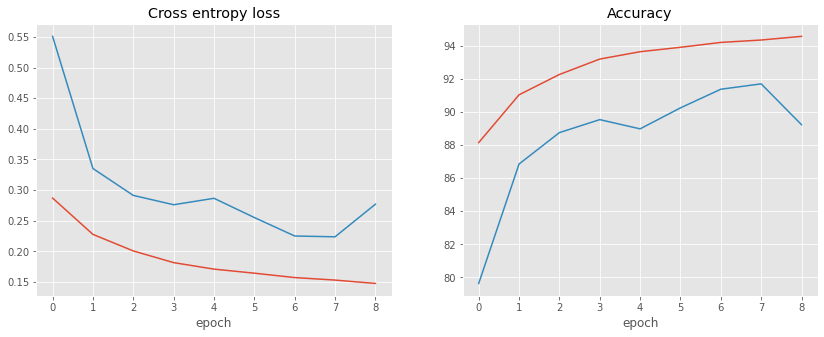

100%|██████████| 688/688 [18:34<00:00,  1.62s/it]


Train Loss: 0.144 | Accuracy: 94.753


100%|██████████| 688/688 [03:00<00:00,  3.82it/s]


Val Loss: 0.229 | Accuracy: 91.415


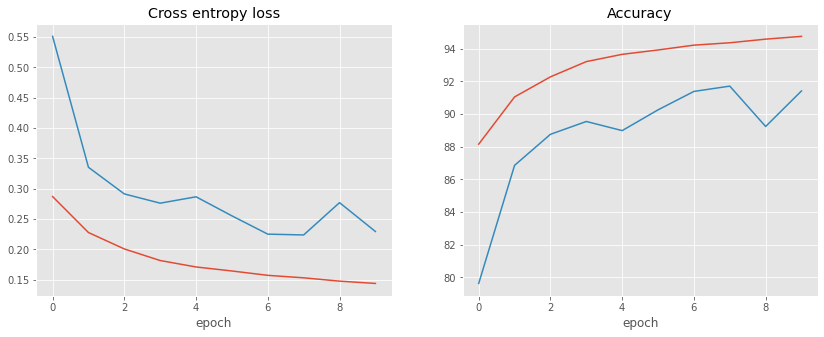

100%|██████████| 688/688 [18:35<00:00,  1.62s/it]


Train Loss: 0.141 | Accuracy: 94.837


100%|██████████| 688/688 [02:57<00:00,  3.88it/s]


Val Loss: 0.253 | Accuracy: 90.165


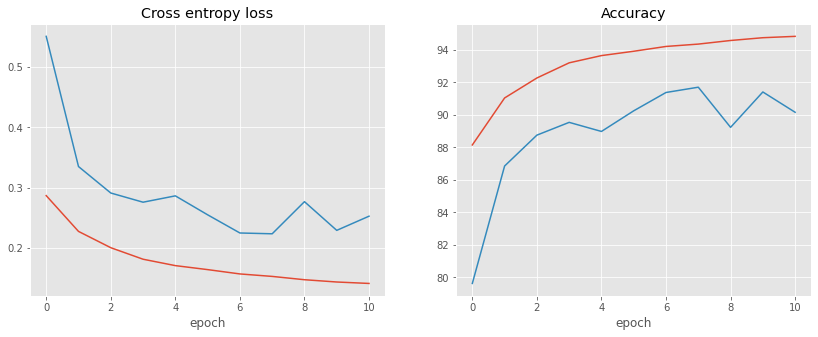

100%|██████████| 688/688 [18:35<00:00,  1.62s/it]


Train Loss: 0.138 | Accuracy: 94.977


100%|██████████| 688/688 [02:58<00:00,  3.85it/s]


Val Loss: 0.255 | Accuracy: 90.433


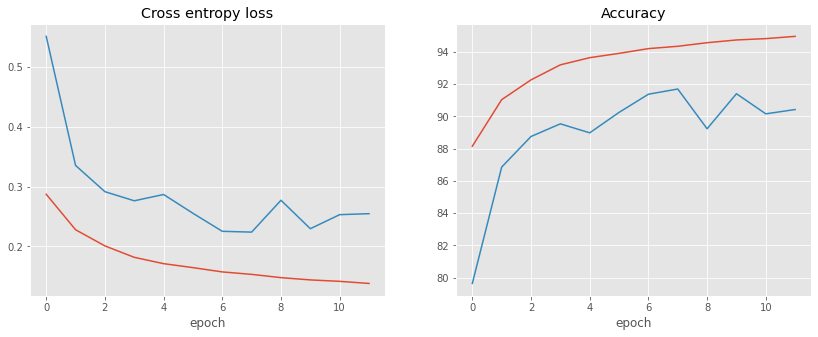

100%|██████████| 688/688 [18:33<00:00,  1.62s/it]


Train Loss: 0.135 | Accuracy: 95.101


100%|██████████| 688/688 [02:56<00:00,  3.89it/s]


Val Loss: 0.207 | Accuracy: 92.033


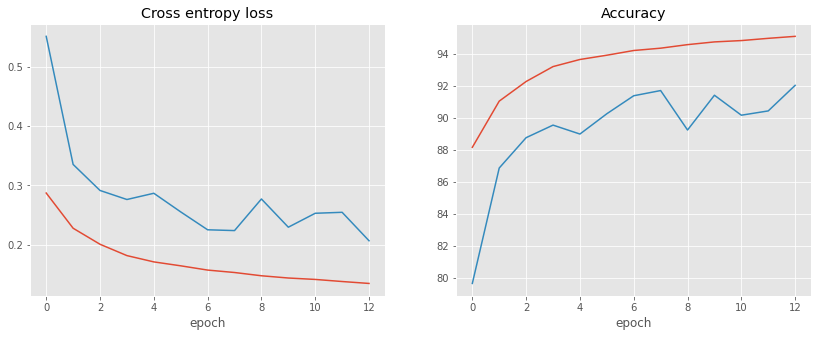

100%|██████████| 688/688 [18:20<00:00,  1.60s/it]


Train Loss: 0.132 | Accuracy: 95.241


100%|██████████| 688/688 [02:57<00:00,  3.87it/s]


Val Loss: 0.225 | Accuracy: 91.487


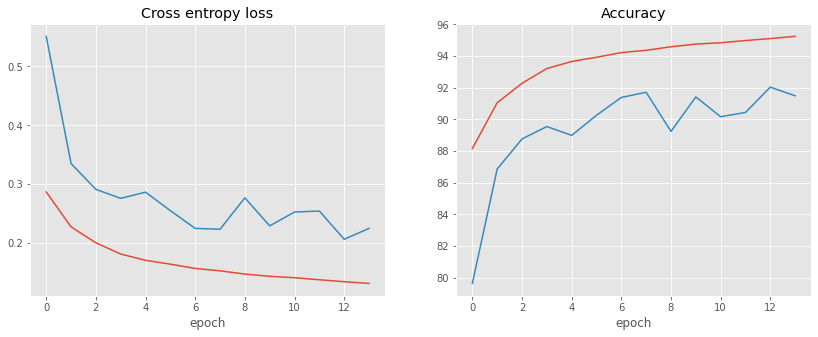

100%|██████████| 688/688 [18:21<00:00,  1.60s/it]


Train Loss: 0.129 | Accuracy: 95.335


100%|██████████| 688/688 [02:57<00:00,  3.88it/s]


Val Loss: 0.218 | Accuracy: 91.815


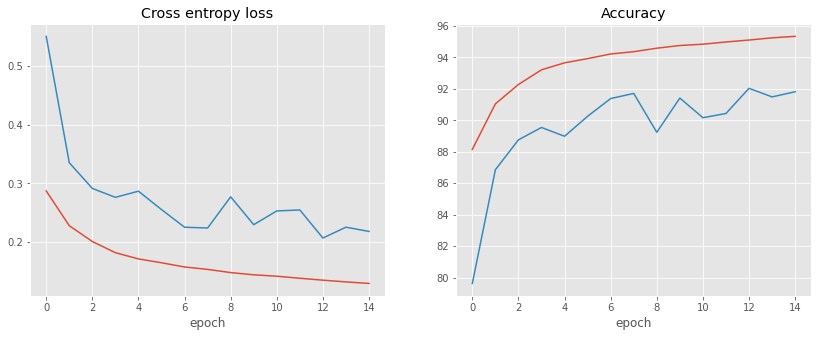

 53%|█████▎    | 366/688 [09:41<08:39,  1.61s/it]

In [ ]:
epochs=20
for epoch in range(1,epochs+1): 
    train(train_loader)
    val(valid_loader)
    fig, (loss_plot, acc_plot) = plt.subplots(1, 2, figsize=(14, 5))
    loss_plot.plot(train_losses, label="train")
    loss_plot.plot(eval_losses, label = "val")
    acc_plot.plot(train_accu, label="train")
    acc_plot.plot(eval_accu, label = "val")
    loss_plot.set_xlabel('epoch'), acc_plot.set_xlabel('epoch')
    loss_plot.set_title('Cross entropy loss'), acc_plot.set_title('Accuracy')
    plt.show()
    torch.save(model.state_dict(), f'model_{epoch}.ckpt')

In [49]:
eval_losses, train_losses = [0.551, 0.335, 0.291, 0.276, 0.287, 0.255, 0.225, 0.224, 0.227, 0.229, 0.253, 0.255, 0.207, 0.225, 0.218], [0.287, 0.228, 0.201, 0.182, 0.171, 0.164, 0.157, 0.153, 0.148, 0.144, 0.141, 0.138, 0.135, 0.132, 0.129]
eval_accu, train_accu = [79.632, 86.858, 88.758, 89.544, 88.985, 90.256, 91.383, 91.708, 89.238, 91.415, 90.165, 90.433, 92.033, 91.487, 91.815], [88.154, 91.046, 92.275, 93.208, 93.653, 93.920, 94.215, 94.361, 94.582, 94.753, 94.837, 94.977, 95.101, 95.241, 95.335]

100%|██████████| 688/688 [17:57<00:00,  1.57s/it]


Train Loss: 0.131 | Accuracy: 95.234


100%|██████████| 688/688 [02:50<00:00,  4.04it/s]


Val Loss: 0.113 | Accuracy: 96.066


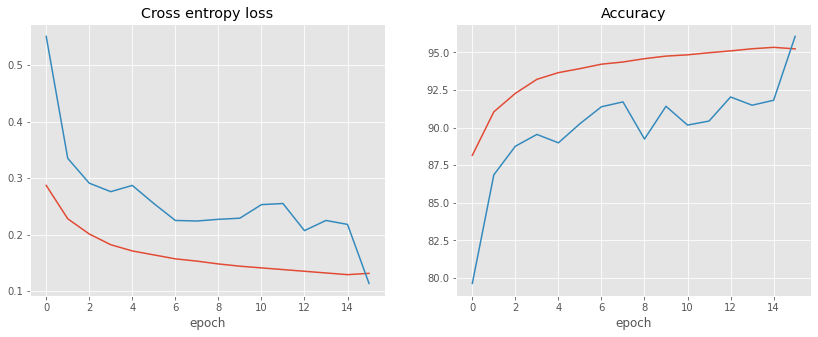

100%|██████████| 688/688 [18:07<00:00,  1.58s/it]


Train Loss: 0.129 | Accuracy: 95.318


100%|██████████| 688/688 [02:48<00:00,  4.07it/s]


Val Loss: 0.128 | Accuracy: 95.587


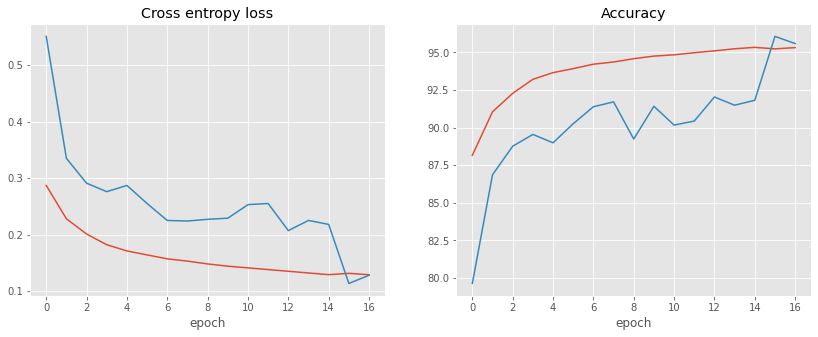

100%|██████████| 688/688 [17:58<00:00,  1.57s/it]


Train Loss: 0.132 | Accuracy: 95.239


100%|██████████| 688/688 [02:46<00:00,  4.13it/s]


Val Loss: 0.128 | Accuracy: 95.503


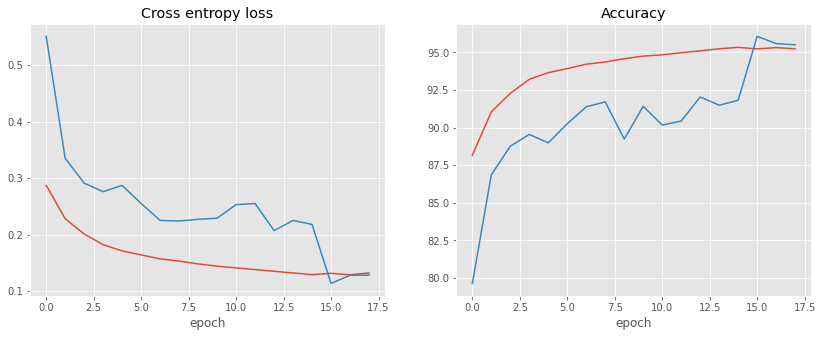

100%|██████████| 688/688 [18:19<00:00,  1.60s/it]


Train Loss: 0.131 | Accuracy: 95.206


100%|██████████| 688/688 [02:48<00:00,  4.08it/s]


Val Loss: 0.121 | Accuracy: 96.030


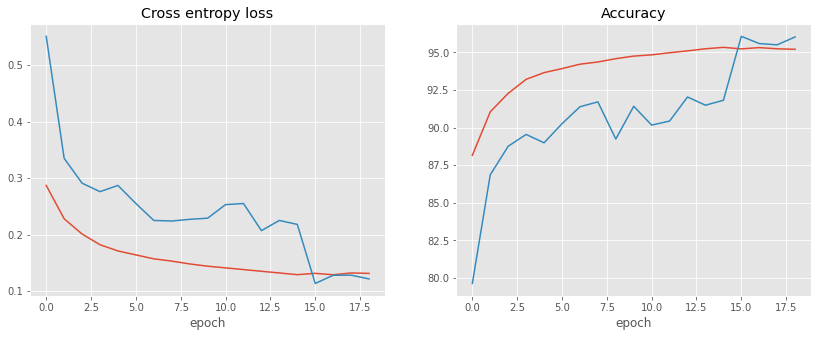

100%|██████████| 688/688 [18:18<00:00,  1.60s/it]


Train Loss: 0.125 | Accuracy: 95.528


100%|██████████| 688/688 [02:52<00:00,  3.98it/s]


Val Loss: 0.137 | Accuracy: 95.414


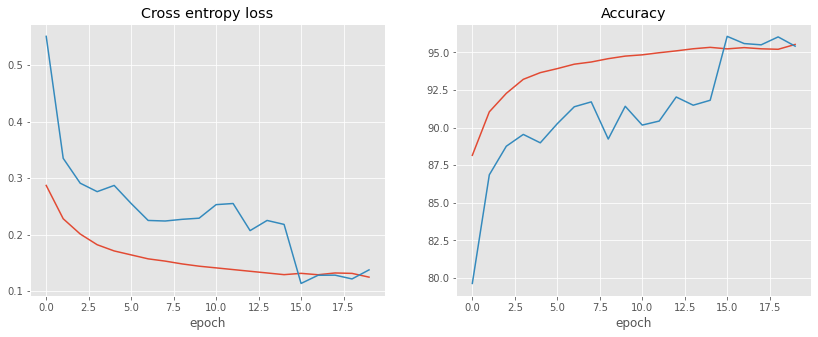

  2%|▏         | 13/688 [00:22<19:06,  1.70s/it]


KeyboardInterrupt: ignored

In [50]:
epochs=10
for epoch in range(1,epochs+1): 
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size // 4, shuffle=False, num_workers=0)
    train(train_loader)
    val(valid_loader)
    fig, (loss_plot, acc_plot) = plt.subplots(1, 2, figsize=(14, 5))
    loss_plot.plot(train_losses, label="train")
    loss_plot.plot(eval_losses, label = "val")
    acc_plot.plot(train_accu, label="train")
    acc_plot.plot(eval_accu, label = "val")
    loss_plot.set_xlabel('epoch'), acc_plot.set_xlabel('epoch')
    loss_plot.set_title('Cross entropy loss'), acc_plot.set_title('Accuracy')
    plt.show()
    torch.save(model.state_dict(), f'model_{epoch}.ckpt')

In [61]:
sub_df = pd.read_csv('/content/sample_submission.csv')
dataset_valid = MyDataset(sub_df, test_path, test_transform)
loader_test = DataLoader(dataset = dataset_valid, batch_size=32, shuffle=False, num_workers=0)

In [62]:
model.eval()

preds = []
for batch_i, (data, target) in enumerate(loader_test):
    data, target = data.cuda(), target.cuda()
    output = model(data)

    pr = output[:,1].detach().cpu().numpy()
    for i in pr:
        preds.append(i)

In [63]:
sub_df['label'] = preds
sub_df.to_csv("/content/submission.csv", index=False)
